In [147]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import patsy

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, power_transform
from sklearn.pipeline import Pipeline

(0.6313725490196078, 0.788235294117647, 0.9568627450980393)


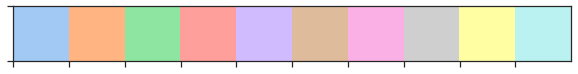

In [148]:
# Set styles for plots 
sns.set('notebook')
sns.set_style('ticks')
sns.set_palette('pastel')

# Extract RGB codes from color_palette to style plots
color_list = sns.color_palette('pastel')
print(color_list[0])

sns.palplot(sns.color_palette('pastel'))

In [149]:
with open('kickstarter_datafull.pickle', 'rb') as f:
    df = pickle.load(f)

In [150]:
print(df.shape)
df.head()

(194318, 21)


,backers_count,country,created_at,deadline,goal,launched_at,name,spotlight,staff_pick,state,...,usd_pledged,category,subcategory,project_url,project_life,campaign_length,launch_month,deadline_month,daily_amount_pledged,daily_backers
0,1,US,2016-09-11 22:05:51,2016-12-05 19:42:23,5000.0,2016-11-05 18:42:23,Industrial Bamboo Table,False,False,failed,...,240.000000,crafts,woodworking,https://www.kickstarter.com/projects/983022919...,84,30,2016-11,2016-12,8.0,0.0333
1,3,CA,2015-07-10 14:59:32,2015-08-24 12:00:34,1000.0,2015-07-21 12:00:34,"Custom Pet Portraits on Canvas- ""From Pixels t...",False,False,failed,...,247.950175,art,painting,https://www.kickstarter.com/projects/101531536...,44,34,2015-07,2015-08,7.0,0.0882
2,243,US,2015-03-24 17:41:14,2015-05-15 16:22:34,35000.0,2015-04-15 16:22:34,The Barmobile: Boston's Mobile Cocktail Cateri...,True,True,successful,...,41738.000000,food,food trucks,https://www.kickstarter.com/projects/372111659...,51,30,2015-04,2015-05,1391.0,8.1000
3,27,US,2017-05-18 12:30:32,2017-07-16 15:03:03,3000.0,2017-06-01 15:03:03,Grandfather Thunder & The Night Horses,True,False,successful,...,3115.000000,publishing,children's books,https://www.kickstarter.com/projects/133655246...,59,45,2017-06,2017-07,69.0,0.6000
4,3,US,2017-06-11 02:02:05,2017-09-09 19:17:10,250000.0,2017-08-10 19:17:10,Parker's Cup Coffee & Tea,False,False,failed,...,61.000000,food,drinks,https://www.kickstarter.com/projects/107038669...,90,30,2017-08,2017-09,2.0,0.1000


In [151]:
# Additional filter --> only US projects
df = df.loc[df['country'] == 'US']

<font color="red">RANDOM IDEA FOR OTHER TARGET</font> --> Predict how much over/under the goal a project will be. Can use daily backers and daily pledge amounts as "velocity" terms, the goal itself would come into play here, as well as the time marketed and campaign length...

# Data preprocesing and dummy variables

In [152]:
# Goal differential
df['goal_diff'] = df['usd_pledged'] - df['goal']

In [153]:
# Goal differential (as a percentage)
df['goal_diff_perc'] = (df['usd_pledged'] - df['goal']) / df['goal']

In [154]:
# Spot check for calculation accuracy
df.loc[:, ['goal', 'usd_pledged', 'goal_diff', 'goal_diff_perc']].sample(20)

,goal,usd_pledged,goal_diff,goal_diff_perc
100572,112.0,124.00,12.00,0.107143
44294,6000.0,7640.00,1640.00,0.273333
66550,21040.0,210.00,-20830.00,-0.990019
179221,7500.0,229.00,-7271.00,-0.969467
160880,2013.0,3083.77,1070.77,0.531927
91751,20000.0,21410.00,1410.00,0.070500
168074,5000.0,5107.00,107.00,0.021400
147213,15000.0,15165.00,165.00,0.011000
44661,2500.0,10472.00,7972.00,3.188800
55081,1000.0,13.00,-987.00,-0.987000


Stick to pledge amount rather than % difference...maybe in the other model when I factor in social I can find something more interesting. For now, keep it simple. There's too much variability in the differential with different funding goals to really predict that...? Unless there's an external factor involved.

Foregoing `project_life` since it is redundant with `campaign_length`. Going to calculate the time from creation to launch instead, so that they are separated.

In [155]:
# Time between project creation and launch
df['creation_to_launch'] = (df['launched_at'] - df['created_at']).dt.days

In [156]:
# Seasonal component
# Create bins for months to fall under each season
winter = [12, 1, 2]
spring = [3, 4, 5]
summer = [6, 7, 8]
fall = [9, 10, 11]

In [157]:
# Create a function to evaluate the month from the launch date
def season(row):
    if row['launched_at'].month in winter:
        season = 'winter'
    elif row['launched_at'].month in spring:
        season = 'spring'
    elif row['launched_at'].month in summer:
        season = 'summer'
    else:
        season = 'fall'
    return season

In [158]:
# Create new column classifying what season the project was launched
df['season_launched'] = df.apply(season, axis=1)
df.head()

,backers_count,country,created_at,deadline,goal,launched_at,name,spotlight,staff_pick,state,...,project_life,campaign_length,launch_month,deadline_month,daily_amount_pledged,daily_backers,goal_diff,goal_diff_perc,creation_to_launch,season_launched
0,1,US,2016-09-11 22:05:51,2016-12-05 19:42:23,5000.0,2016-11-05 18:42:23,Industrial Bamboo Table,False,False,failed,...,84,30,2016-11,2016-12,8.0,0.0333,-4760.0,-0.952000,54,fall
2,243,US,2015-03-24 17:41:14,2015-05-15 16:22:34,35000.0,2015-04-15 16:22:34,The Barmobile: Boston's Mobile Cocktail Cateri...,True,True,successful,...,51,30,2015-04,2015-05,1391.0,8.1000,6738.0,0.192514,21,spring
3,27,US,2017-05-18 12:30:32,2017-07-16 15:03:03,3000.0,2017-06-01 15:03:03,Grandfather Thunder & The Night Horses,True,False,successful,...,59,45,2017-06,2017-07,69.0,0.6000,115.0,0.038333,14,summer
4,3,US,2017-06-11 02:02:05,2017-09-09 19:17:10,250000.0,2017-08-10 19:17:10,Parker's Cup Coffee & Tea,False,False,failed,...,90,30,2017-08,2017-09,2.0,0.1000,-249939.0,-0.999756,60,summer
5,1,US,2015-08-18 02:36:53,2015-10-18 21:17:17,125.0,2015-08-19 21:17:17,Disorderly Conduct's First Album,False,False,failed,...,61,60,2015-08,2015-10,0.0,0.0167,-120.0,-0.960000,1,summer


#### Exploratory Data Analysis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137800 entries, 0 to 194315
Data columns (total 25 columns):
backers_count           137800 non-null int64
country                 137800 non-null object
created_at              137800 non-null datetime64[ns]
deadline                137800 non-null datetime64[ns]
goal                    137800 non-null float64
launched_at             137800 non-null datetime64[ns]
name                    137800 non-null object
spotlight               137800 non-null bool
staff_pick              137800 non-null bool
state                   137800 non-null object
state_changed_at        137800 non-null datetime64[ns]
usd_pledged             137800 non-null float64
category                137800 non-null object
subcategory             137800 non-null object
project_url             137800 non-null object
project_life            137800 non-null int64
campaign_length         137800 non-null int64
launch_month            137800 non-null period[M]
deadline_mont

In [14]:
df.describe()

,backers_count,goal,usd_pledged,project_life,campaign_length,daily_amount_pledged,daily_backers,goal_diff,goal_diff_perc,creation_to_launch
count,137800.000000,1.378000e+05,1.378000e+05,137800.000000,137800.000000,137800.000000,137800.000000,1.378000e+05,137800.000000,137800.000000
mean,166.906858,3.715569e+04,1.488516e+04,83.621422,32.421168,486.992779,5.760245,-2.227052e+04,4.676394,50.971212
std,1053.476215,9.735099e+05,1.112854e+05,145.493592,11.848415,3656.237130,38.407022,9.786928e+05,288.889725,144.715928
min,0.000000,1.000000e-02,0.000000e+00,1.000000,1.000000,0.000000,0.000000,-1.000000e+08,-1.000000,0.000000
25%,4.000000,1.500000e+03,1.370000e+02,33.000000,29.000000,4.000000,0.133300,-4.539000e+03,-0.968262,3.000000
50%,30.000000,5.000000e+03,1.825000e+03,47.000000,30.000000,64.000000,1.033300,7.000000e+01,0.024100,11.000000
75%,96.000000,1.375550e+04,7.226500e+03,74.000000,34.000000,247.000000,3.344800,8.730000e+02,0.260000,38.000000
max,105857.000000,1.000000e+08,1.214344e+07,3333.000000,97.000000,332646.000000,3052.833300,1.164344e+07,68763.100000,3303.000000


Filter dataframe to remove unused columns for regression

In [15]:
# Select columns used for regression
columns = ['usd_pledged', 'backers_count', 'goal', 'spotlight', 'staff_pick', 'category', 'campaign_length',
          'creation_to_launch', 'season_launched']

In [16]:
kickstarter_df = df.loc[:, columns]
kickstarter_df

,usd_pledged,backers_count,goal,spotlight,staff_pick,category,campaign_length,creation_to_launch,season_launched
0,240.0,1,5000.0,False,False,crafts,30,54,fall
2,41738.0,243,35000.0,True,True,food,30,21,spring
3,3115.0,27,3000.0,True,False,publishing,45,14,summer
4,61.0,3,250000.0,False,False,food,30,60,summer
5,5.0,1,125.0,False,False,music,60,1,summer
...,...,...,...,...,...,...,...,...,...
194308,1.0,1,30000.0,False,False,film & video,60,0,fall
194311,304.0,11,300.0,True,False,art,30,54,fall
194312,564.0,23,200.0,True,False,art,9,5,fall
194313,657.0,33,200.0,True,False,art,30,0,fall


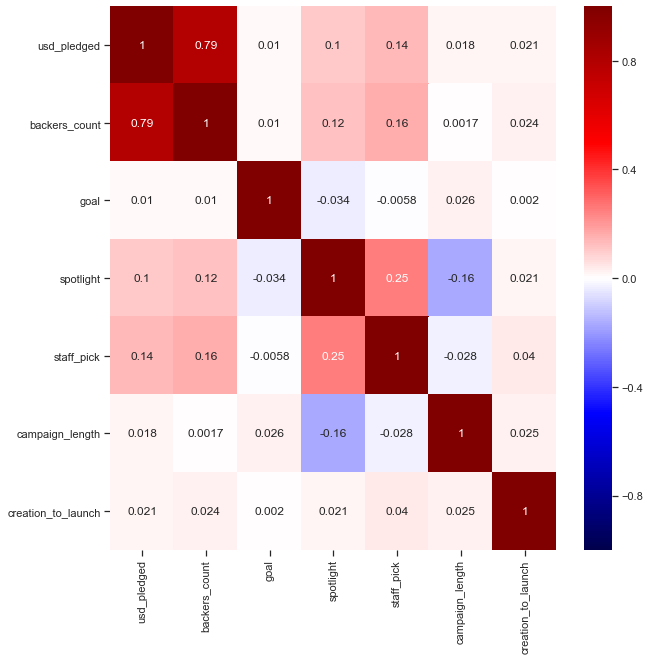

In [17]:
# Create heatmap displaying visualization of feature correlation
plt.figure(figsize=[10,10])
sns.heatmap(kickstarter_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

- There seems to be high correlation between the amount pledged, the number of backers, and the average backers/funding per day.
- It's interesting that the campaign length and funding goal don't have more of an effect on the pledge amount.

In [18]:
# Convert boolean columns to zeroes and ones
kickstarter_df['spotlight'] = kickstarter_df['spotlight'].astype(int)
kickstarter_df['staff_pick'] = kickstarter_df['staff_pick'].astype(int)
kickstarter_df.head()

,usd_pledged,backers_count,goal,spotlight,staff_pick,category,campaign_length,creation_to_launch,season_launched
0,240.0,1,5000.0,0,0,crafts,30,54,fall
2,41738.0,243,35000.0,1,1,food,30,21,spring
3,3115.0,27,3000.0,1,0,publishing,45,14,summer
4,61.0,3,250000.0,0,0,food,30,60,summer
5,5.0,1,125.0,0,0,music,60,1,summer


In [19]:
# Get dummy variables for categories
kickstarter_df = pd.get_dummies(kickstarter_df)
kickstarter_df.head()

,usd_pledged,backers_count,goal,spotlight,staff_pick,campaign_length,creation_to_launch,category_art,category_comics,category_crafts,...,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,season_launched_fall,season_launched_spring,season_launched_summer,season_launched_winter
0,240.0,1,5000.0,0,0,30,54,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,41738.0,243,35000.0,1,1,30,21,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3115.0,27,3000.0,1,0,45,14,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,61.0,3,250000.0,0,0,30,60,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,5.0,1,125.0,0,0,60,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


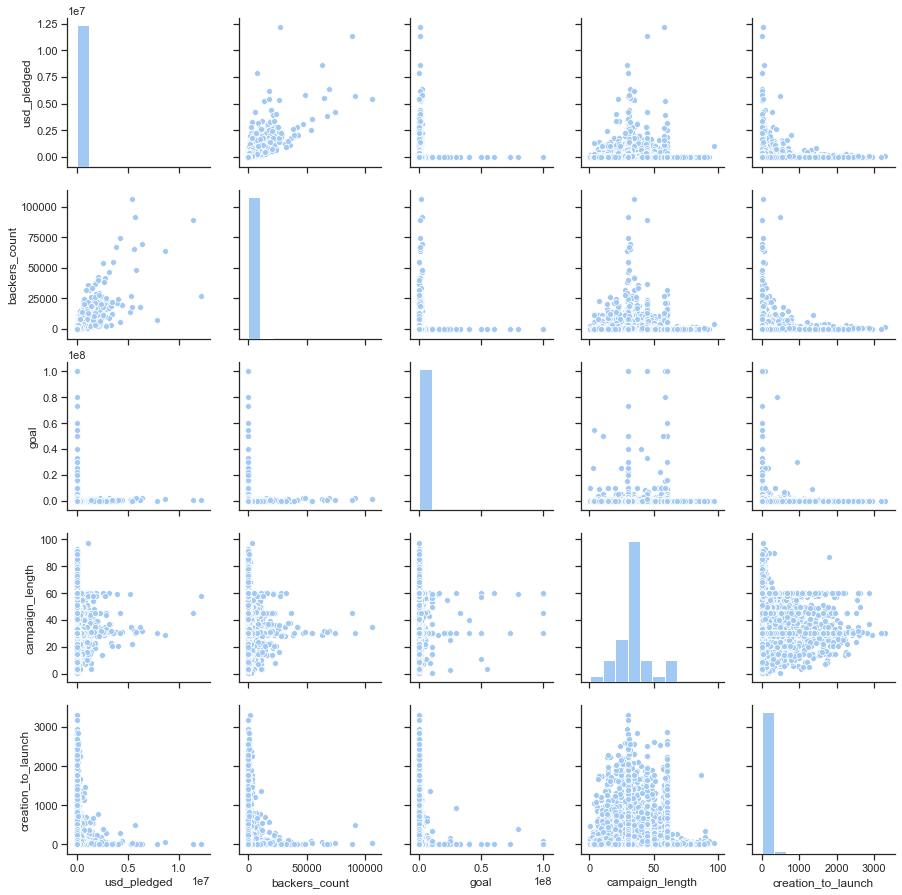

In [20]:
sns.pairplot(kickstarter_df.loc[:, ['usd_pledged', 'backers_count', 'goal', 'campaign_length', 'creation_to_launch']]);

- Target does not follow a normal distribution

<font color='red'><h2>Log Transform</h2></font>

In [21]:
kickstarter_df['usd_pledged'] = np.log(kickstarter_df['usd_pledged'])

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


- Error when plotting the log due to "infinite" values

In [22]:
kickstarter_df[(kickstarter_df['usd_pledged'] == float("-inf")) & (kickstarter_df['backers_count'] == 0)]

,usd_pledged,backers_count,goal,spotlight,staff_pick,campaign_length,creation_to_launch,category_art,category_comics,category_crafts,...,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,season_launched_fall,season_launched_spring,season_launched_summer,season_launched_winter
45,-inf,0,5000.0,0,0,33,8,0,0,0,...,0,1,0,0,0,0,0,0,1,0
51,-inf,0,100.0,0,0,29,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
73,-inf,0,10000.0,0,0,30,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
110,-inf,0,50.0,0,0,15,6,1,0,0,...,0,0,0,0,0,0,0,0,1,0
127,-inf,0,500.0,0,0,21,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186085,-inf,0,15000.0,0,0,19,895,0,0,0,...,0,0,0,0,0,0,0,0,0,1
186385,-inf,0,2000.0,0,0,29,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
186486,-inf,0,10000.0,0,0,30,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
186631,-inf,0,1000.0,0,0,30,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


- 10K rows where there were no backers, showing "infinite" values for pledge amounts. These rows need to be dropped

In [24]:
kickstarter_df = kickstarter_df[(kickstarter_df['usd_pledged'] != float("-inf")) & (kickstarter_df['backers_count'] != 0)]

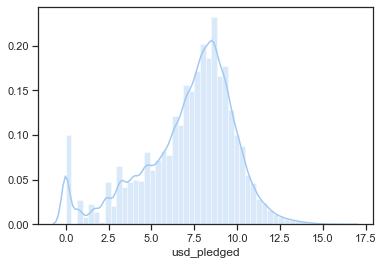

In [25]:
sns.distplot(kickstarter_df['usd_pledged']);

# Split training and test sets

In [78]:
# Segment the training and test sets
X, y = kickstarter_df.drop(['usd_pledged', 'season_launched_fall', 'category_art'], axis=1), kickstarter_df['usd_pledged']
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simple Validation

In [79]:
# Split the training and validations sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Ordinary least squares (OLS)

In [80]:
# Create model and display model statistics
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usd_pledged   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     4251.
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:55:26   Log-Likelihood:            -1.6456e+05
No. Observations:               81611   AIC:                         3.292e+05
Df Residuals:                   81587   BIC:                         3.294e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4.0159      0.030    132.446      0.000       3.956       4.075
backers_count              0.0003   5.83e-06     55.739      0.000       0.000       0.000
goal                   -5.074e-09   8.79e-09     -0.577      0.564   -2.23e-08    1.22e-08
spotlight                  3.6134      0.014    249.894      0.000       3.585       3.642
staff_pick                 1.2616      0.019     66.595      0.000       1.225       1.299
campaign_length            0.0075      0.001     13.541      0.000       0.006       0.009
creation_to_launch         0.0011   4.35e-05     24.228      0.000       0.001       0.001
category_comics            0.2935      0.035      8.329      0.000       0.224       0.363
category_crafts           -0.2802      0.041     -6.803      0.000      -0.361      -0.200
category_dance             0.1189      0.048      2.460      0.014       0.024       0.214
category_design            1.0065      0.039     26.021      0.000       0.931       1.082
category_fashion           0.3703      0.034     10.860      0.000       0.303       0.437
category_film & video      0.5867      0.026     22.744      0.000       0.536       0.637
category_food              0.6487      0.030     21.516      0.000       0.590       0.708
category_games             0.8735      0.031     28.307      0.000       0.813       0.934
category_journalism       -0.1987      0.051     -3.898      0.000      -0.299      -0.099
category_music             0.2730      0.025     10.953      0.000       0.224       0.322
category_photography       0.1244      0.044      2.839      0.005       0.039       0.210
category_publishing        0.2021      0.027      7.358      0.000       0.148       0.256
category_technology        1.2095      0.029     42.006      0.000       1.153       1.266
category_theater           0.3403      0.046      7.444      0.000       0.251       0.430
season_launched_spring    -0.0635      0.018     -3.618      0.000      -0.098      -0.029
season_launched_summer    -0.1303      0.018     -7.411      0.000      -0.165      -0.096
season_launched_winter    -0.2455      0.019    -13.028      0.000      -0.282      -0.209
==============================================================================
Omnibus:                     7807.133   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22980.896
Skew:                          -0.518   Prob(JB):                         0.00
Kurtosis:                       5.384   Cond. No.                     9.20e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+06. This 

#### LR, Lasso, Ridge, and Polynomial regression

In [81]:
# Create list of non-categorical columns to scale
columns_to_scale = ['backers_count', 'goal', 'campaign_length', 'creation_to_launch']

In [82]:
# Set up the models
lm = LinearRegression()
# Ridge and Lasso model alphas assessed in the MAE calcs in the section below
lm_ridge = Ridge(alpha=0.01)
lm_lasso = Lasso(alpha=0.01)
lm_poly = LinearRegression()

# Feature scaling for train, val, and test for ridge and lasso models
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_train_scaled = np.array(X_train_scaled)

X_val_scaled = X_val.copy()
X_val_scaled[columns_to_scale] = scaler.fit_transform(X_val_scaled[columns_to_scale])
X_val_scaled = np.array(X_val_scaled)

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.fit_transform(X_test_scaled[columns_to_scale])
X_test_scaled = np.array(X_test_scaled)

# Feature transforms for train, val, and test
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

In [83]:
# Validate all models and display the results
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.5f}')

lm_ridge.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_ridge.score(X_val_scaled, y_val):.5f}')

lm_lasso.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_lasso.score(X_val_scaled, y_val):.5f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 Polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.5f}')

Linear Regression val R^2: 0.54848
Ridge Regression val R^2: 0.54980
Lasso Regression val R^2: 0.54566
Degree 2 Polynomial regression val R^2: 0.55999


<font color='blue'><h4>Takeaways</h4></font>
- After tuning the Ridge and Lasso model alphas, regular linear regression is still the best predictor of the response.
- The Lasso coeffs show that some of the categories can be grouped into an "Other" category, as they show little effect on the model.
- Seasonal shifts are not present in Kickstarter backing. These features can be removed in the next iteration.

#### Observe Ridge and Lasso coefficients

In [84]:
# Ridge coefficients
list(zip(X_train.columns, lm_ridge.coef_))

[('backers_count', 0.3649940352647363),
 ('goal', -0.0036760685369858865),
 ('spotlight', 3.6134021193057793),
 ('staff_pick', 1.2616340009881744),
 ('campaign_length', 0.08810277209639493),
 ('creation_to_launch', 0.15475932204967874),
 ('category_comics', 0.293522054829233),
 ('category_crafts', -0.2802536252818543),
 ('category_dance', 0.11889905758639611),
 ('category_design', 1.006450484223501),
 ('category_fashion', 0.37031803927125995),
 ('category_film & video', 0.5866667323676524),
 ('category_food', 0.648696139110646),
 ('category_games', 0.8734921477907367),
 ('category_journalism', -0.1986655238715459),
 ('category_music', 0.27299658583547204),
 ('category_photography', 0.12442779753210577),
 ('category_publishing', 0.2020628415751588),
 ('category_technology', 1.2094799238361196),
 ('category_theater', 0.3403257850786426),
 ('season_launched_spring', -0.06351613535313272),
 ('season_launched_summer', -0.13025267507870278),
 ('season_launched_winter', -0.2455217184347488)]

In [85]:
# Lasso coefficients
list(zip(X_train.columns, lm_lasso.coef_))

[('backers_count', 0.37459069822475194),
 ('goal', -0.0),
 ('spotlight', 3.571629710709666),
 ('staff_pick', 1.1909980891264904),
 ('campaign_length', 0.07958082424682884),
 ('creation_to_launch', 0.15622466554454564),
 ('category_comics', 0.0),
 ('category_crafts', -0.22790344919402433),
 ('category_dance', -0.0),
 ('category_design', 0.46535606425864445),
 ('category_fashion', 0.0),
 ('category_film & video', 0.24876154834448627),
 ('category_food', 0.2420481825477647),
 ('category_games', 0.46346380212040506),
 ('category_journalism', -0.0),
 ('category_music', 0.0),
 ('category_photography', -0.0),
 ('category_publishing', -0.0),
 ('category_technology', 0.8263834612032736),
 ('category_theater', 0.0),
 ('season_launched_spring', 0.0),
 ('season_launched_summer', -0.02807660452655154),
 ('season_launched_winter', -0.13343901470486416)]

### Tune regularization strength

In [86]:
# Define mean absolute error calculation (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

#### Tune Lasso regularization

In [87]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):  
    
    lm_lasso = Lasso(alpha=curr_alpha)
    lm_lasso.fit(X_train_scaled, y_train)
    
    val_set_pred = lm_lasso.predict(X_val_scaled)
    err_vec_val[i] = mae(y_val, val_set_pred)

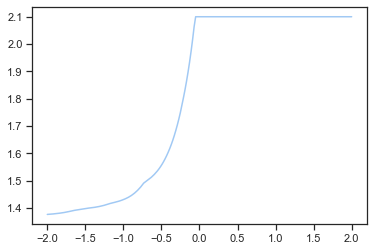

In [88]:
# Plot curve of validation error with change in alpha 
plt.plot(np.log10(alphalist), err_vec_val);

In [89]:
# Minimum error achieved
np.min(err_vec_val)

1.37622425638636

In [90]:
# Alpha value where minimum error reached
alphalist[np.argmin(err_vec_val)]

0.01

#### Tune Ridge regularization

In [91]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):
    
    lm_ridge = Ridge(alpha=curr_alpha)
    lm_ridge.fit(X_train_scaled, y_train)
    
    val_set_pred = lm_ridge.predict(X_val_scaled)
    err_vec_val[i] = mae(y_val, val_set_pred)

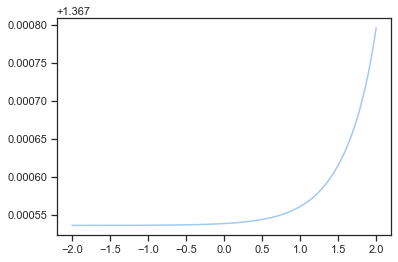

In [92]:
# Plot curve of validation error with change in alpha 
plt.plot(np.log10(alphalist), err_vec_val);

In [93]:
# Minimum error achieved
np.min(err_vec_val)

1.367536542788983

In [94]:
# Alpha value where minimum error reached
alphalist[np.argmin(err_vec_val)]

0.01

#### Calculate VIFs

In [43]:
vif = pd.DataFrame()

X_numeric = X.loc[:, columns_to_scale]
vif["VIF Factor"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
vif["features"] = X_numeric.columns

In [44]:
vif.sort_values('VIF Factor', ascending=False)

,VIF Factor,features
2,1.140003,campaign_length
3,1.117433,creation_to_launch
0,1.025654,backers_count
1,1.002441,goal


- No additional insights as far as multicollinearity other than the features outlined in the LASSO model.

# Additional data processing

- Group unimpactful columns into an `other` category
- Drop `season` columns

In [45]:
# Create a copy of the full dataframe
kickstarter_mod = df.copy()

In [46]:
def re_categorize(category):
    """
    Loop through a pandas Series of urls and scrape their web pages for links to their social accounts.

    Paramater:
    ----------
    category_column: A pandas Series containing categorical columns to group.
    """
    
    categories = ['comics', 'dance', 'fashion', 'journalism', 'music', 'photography', 
                  'publishing', 'theater']
    
    if category in categories:
        return 'other'
    else:
        return category

In [47]:
# Apply function to create new categorization
kickstarter_mod['new_category'] = kickstarter_mod['category'].apply(re_categorize)

In [48]:
# Select columns to keep for new models
columns_to_keep = ['usd_pledged', 'backers_count', 'spotlight', 'staff_pick', 'campaign_length', 
                   'creation_to_launch', 'new_category', 'season_launched']
kickstarter_mod = kickstarter_mod.loc[:, columns_to_keep]
kickstarter_mod = kickstarter_mod.rename(columns={'new_category': 'category'})

In [49]:
# Convert booleans to ints
kickstarter_mod['spotlight'] = kickstarter_mod['spotlight'].astype(int)
kickstarter_mod['staff_pick'] = kickstarter_mod['staff_pick'].astype(int)

In [50]:
kickstarter_mod['usd_pledged'] = np.log(kickstarter_mod['usd_pledged'])
kickstarter_mod = kickstarter_mod[(kickstarter_mod['usd_pledged'] != float("-inf")) & (kickstarter_mod['backers_count'] != 0)]

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [51]:
kickstarter_mod.head()

,usd_pledged,backers_count,spotlight,staff_pick,campaign_length,creation_to_launch,category,season_launched
0,5.480639,1,0,0,30,54,crafts,fall
2,10.639167,243,1,1,30,21,food,spring
3,8.043984,27,1,0,45,14,other,summer
4,4.110874,3,0,0,30,60,food,summer
5,1.609438,1,0,0,60,1,other,summer


In [52]:
# Get dummies for update dataframe
kickstarter_mod = pd.get_dummies(kickstarter_mod)
kickstarter_mod.drop('category_other', axis=1, inplace=True)
print(kickstarter_mod.shape)
kickstarter_mod.head()

(127518, 17)


,usd_pledged,backers_count,spotlight,staff_pick,campaign_length,creation_to_launch,category_art,category_crafts,category_design,category_film & video,category_food,category_games,category_technology,season_launched_fall,season_launched_spring,season_launched_summer,season_launched_winter
0,5.480639,1,0,0,30,54,0,1,0,0,0,0,0,1,0,0,0
2,10.639167,243,1,1,30,21,0,0,0,0,1,0,0,0,1,0,0
3,8.043984,27,1,0,45,14,0,0,0,0,0,0,0,0,0,1,0
4,4.110874,3,0,0,30,60,0,0,0,0,1,0,0,0,0,1,0
5,1.609438,1,0,0,60,1,0,0,0,0,0,0,0,0,0,1,0


In [53]:
# Segment the training and test sets
X, y = kickstarter_mod.drop('usd_pledged', axis=1), kickstarter_mod['usd_pledged']
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-run OLS

In [54]:
# Split the training and validations sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Create model and display model statistics
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usd_pledged   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     6498.
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:54:14   Log-Likelihood:            -1.6463e+05
No. Observations:               81611   AIC:                         3.293e+05
Df Residuals:                   81595   BIC:                         3.294e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.3106      0.019    174.639      0.000       3.273       3.348
backers_count              0.0003   5.83e-06     55.773      0.000       0.000       0.000
spotlight                  3.6251      0.014    253.547      0.000       3.597       3.653
staff_pick                 1.2501      0.019     66.277      0.000       1.213       1.287
campaign_length            0.0074      0.001     13.493      0.000       0.006       0.009
creation_to_launch         0.0011   4.35e-05     24.500      0.000       0.001       0.001
category_art              -0.2378      0.021    -11.152      0.000      -0.280      -0.196
category_crafts           -0.5165      0.038    -13.645      0.000      -0.591      -0.442
category_design            0.7675      0.035     21.948      0.000       0.699       0.836
category_film & video      0.3490      0.020     17.599      0.000       0.310       0.388
category_food              0.4142      0.025     16.343      0.000       0.365       0.464
category_games             0.6345      0.026     24.337      0.000       0.583       0.686
category_technology        0.9739      0.024     41.189      0.000       0.928       1.020
season_launched_fall       0.9387      0.012     78.845      0.000       0.915       0.962
season_launched_spring     0.8743      0.012     74.428      0.000       0.851       0.897
season_launched_summer     0.8073      0.012     69.190      0.000       0.784       0.830
season_launched_winter     0.6903      0.013     53.381      0.000       0.665       0.716
==============================================================================
Omnibus:                     7763.330   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22857.729
Skew:                          -0.515   Prob(JB):                         0.00
Kurtosis:                       5.379   Cond. No.                     3.34e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.44e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Cross validation testing

In [56]:
def cv_test_data(model, X, y):
    """
    Run a specified model using X and y values passed and return the R^2, mean R^2, and std.
    
    Parameters:
    -----------
    model: Model you are testing
    X: 2D array of features
    y: Array of target values 
    """
    
    # Set the number of folds and initialize container of r^2 and adj r^2 values
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_model_r2s, cv_model_adj_r2s = [], []
    
    for train_ind, val_ind in kf.split(X,y):
        
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Append r^2 scores
        val_score = model.score(X_val, y_val)
        cv_model_r2s.append(val_score)
        
        # Append adj r^2 scores
        adj_r_squared = 1 - (1-val_score)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
        cv_model_adj_r2s.append(adj_r_squared)
        
    print('Model r^2 scores: ', cv_model_r2s)
    print('Model adj r^2 scores: ', cv_model_adj_r2s, '\n')
    
    print(f'Mean cv r^2: {np.mean(cv_model_r2s):.3f} +- {np.std(cv_model_r2s):.3f}')
    print(f'Mean adj cv r^2: {np.mean(cv_model_adj_r2s):.3f} +- {np.std(cv_model_adj_r2s):.3f}', '\n')

#### Linear regression

In [57]:
cv_test_data(LinearRegression(), np.array(X), np.array(y))

Model r^2 scores:  [0.5471483480215535, 0.5392656862848973, 0.529226202049512, 0.5529034630722172, 0.5489595992462536]
Model adj r^2 scores:  [0.5467929263384547, 0.5389040778762129, 0.528856714128036, 0.5525525583046882, 0.5486055817622182] 

Mean cv r^2: 0.544 +- 0.008
Mean adj cv r^2: 0.543 +- 0.008 



#### Ridge regression

In [58]:
# Scale features for ridge and lasso models
scaler = StandardScaler()

columns_to_scale = ['backers_count', 'campaign_length', 'creation_to_launch']

X_scaled = X.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])
X_scaled = np.array(X_scaled)

In [59]:
cv_test_data(Ridge(alpha=0.01), X_scaled, np.array(y))

Model r^2 scores:  [0.5471483482063215, 0.5392656986629715, 0.5292261828062605, 0.552903455420737, 0.5489596083118816]
Model adj r^2 scores:  [0.5467929265233675, 0.538904090264002, 0.5288566948696816, 0.5525525506472029, 0.5486055908349619] 

Mean cv r^2: 0.544 +- 0.008
Mean adj cv r^2: 0.543 +- 0.008 



#### Lasso regression

In [60]:
cv_test_data(Lasso(alpha=0.01), X_scaled, np.array(y))

Model r^2 scores:  [0.5449911468918405, 0.537501474744928, 0.5267583554250688, 0.549978636898832, 0.5467458766551099]
Model adj r^2 scores:  [0.5446340321243661, 0.5371384816906711, 0.526386930608371, 0.5496254365746085, 0.5463901216404659] 

Mean cv r^2: 0.541 +- 0.008
Mean adj cv r^2: 0.541 +- 0.008 



#### Polynomial regression

In [61]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X.values)

In [62]:
cv_test_data(LinearRegression(), X_poly, np.array(y))

Model r^2 scores:  [0.558709260505183, 0.6225013407238268, 0.5641960947978051, 0.6274775931261425, 0.6248634242711253]
Model adj r^2 scores:  [0.5553748991469576, 0.6196489877745821, 0.5609031915682167, 0.6246628403851824, 0.6220287790673265] 

Mean cv r^2: 0.600 +- 0.031
Mean adj cv r^2: 0.597 +- 0.031 



# Results

- Linear regression continued to be the best predictor of pledge amount
- Binning of categorical columns, removal of seasonal component, campaign length and project goal resulted in p-values of zero for all other features.

#### Linear regression

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usd_pledged   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     6498.
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:54:17   Log-Likelihood:            -1.6463e+05
No. Observations:               81611   AIC:                         3.293e+05
Df Residuals:                   81595   BIC:                         3.294e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.3106      0.019    174.639      0.000       3.273       3.348
backers_count              0.0003   5.83e-06     55.773      0.000       0.000       0.000
spotlight                  3.6251      0.014    253.547      0.000       3.597       3.653
staff_pick                 1.2501      0.019     66.277      0.000       1.213       1.287
campaign_length            0.0074      0.001     13.493      0.000       0.006       0.009
creation_to_launch         0.0011   4.35e-05     24.500      0.000       0.001       0.001
category_art              -0.2378      0.021    -11.152      0.000      -0.280      -0.196
category_crafts           -0.5165      0.038    -13.645      0.000      -0.591      -0.442
category_design            0.7675      0.035     21.948      0.000       0.699       0.836
category_film & video      0.3490      0.020     17.599      0.000       0.310       0.388
category_food              0.4142      0.025     16.343      0.000       0.365       0.464
category_games             0.6345      0.026     24.337      0.000       0.583       0.686
category_technology        0.9739      0.024     41.189      0.000       0.928       1.020
season_launched_fall       0.9387      0.012     78.845      0.000       0.915       0.962
season_launched_spring     0.8743      0.012     74.428      0.000       0.851       0.897
season_launched_summer     0.8073      0.012     69.190      0.000       0.784       0.830
season_launched_winter     0.6903      0.013     53.381      0.000       0.665       0.716
==============================================================================
Omnibus:                     7763.330   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22857.729
Skew:                          -0.515   Prob(JB):                         0.00
Kurtosis:                       5.379   Cond. No.                     3.34e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.44e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [64]:
test_set_pred = lr.predict(X_test)

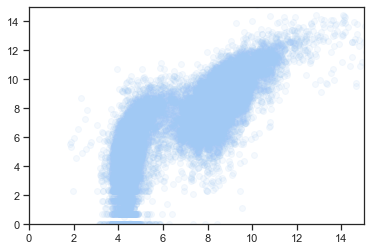

In [95]:
plt.scatter(test_set_pred, y_test, alpha=0.1)
plt.xlim([0, 15])
plt.ylim([0,15]);

#### Lasso regression

In [66]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_train_scaled = np.array(X_train_scaled)

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.fit_transform(X_test_scaled[columns_to_scale])
X_test_scaled = np.array(X_test_scaled)

In [67]:
lr_model_lasso = Lasso(alpha=0.01)
lr_model_lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [68]:
test_set_pred = lr_model_lasso.predict(X_test_scaled)

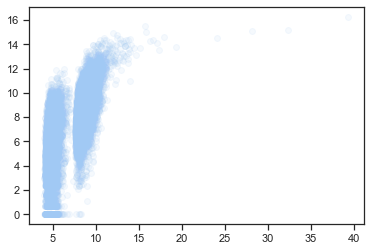

In [69]:
plt.scatter(test_set_pred, y_test, alpha=0.1);

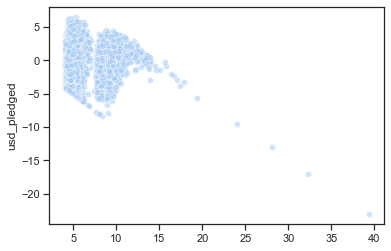

In [70]:
sns.scatterplot(x=test_set_pred, y=y_test-test_set_pred, alpha=0.5);

#### Polynomial regression

In [71]:
lr_poly = LinearRegression()
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lr_poly.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
test_set_pred = lr_poly.predict(X_test_poly)

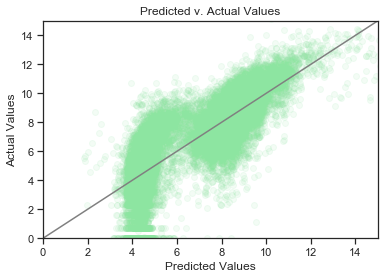

In [145]:
plt.scatter(test_set_pred, y_test, alpha=0.1, color=(0.5529411764705883, 0.8980392156862745, 0.6313725490196078))
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.plot(np.linspace(0, 15, 1000), np.linspace(0, 15, 1000), color='gray')
plt.title('Predicted v. Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.savefig('predicted_values_full.svg', transparent=True, bbox_inches='tight');

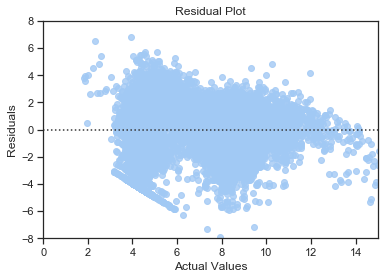

In [146]:
sns.residplot(test_set_pred, y_test, color=(0.6313725490196078, 0.788235294117647, 0.9568627450980393))
plt.xlim([0, 15])
plt.ylim([-8, 8])
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.savefig('residual_plot_full.svg', transparent=True, bbox_inches='tight');